In [1]:
import pandas as pd
import numpy as np
import fix_yahoo_finance as yf
import datetime
from pandas.tseries.offsets import *
import matplotlib.pyplot as plt

In [2]:
now = datetime.datetime.now()
now = now.strftime('%Y-%m-%d')

# Sim settings
bal = 10000
rm = 0.05

In [3]:
# Temp df for yf downloads
df = pd.DataFrame()

symbol_list = ['X', 'PBR', 'BAC', 'CZR', 'AKS', 'AMD', 'TWTR', 'DVN', 'CHK','FCX', 'KORS', 'S', 'MGM', 'GE', 'TEVA', 'THC', 'GPRO', 'MS','RIG', 'IQ']

# Main df we'll put the temp df's on 
main_df = pd.DataFrame()

for sym in symbol_list:
    
    print(sym)
    
    try:
        df = yf.download(sym, '2016-1-1', now)
        
    except ValueError:
        pass
    
    df.rename(columns = {'Adj Close': sym}, inplace=True)
    df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], 1, inplace=True)
    
    if main_df.empty:
        main_df = df
        
    else:
        main_df = main_df.join(df, how='outer', on='Date') 
        
# Now the df is the main_df
df = main_df

X
[*********************100%***********************]  1 of 1 downloaded
PBR
[*********************100%***********************]  1 of 1 downloaded
BAC
[*********************100%***********************]  1 of 1 downloaded
CZR
[*********************100%***********************]  1 of 1 downloaded
AKS
[*********************100%***********************]  1 of 1 downloaded
AMD
[*********************100%***********************]  1 of 1 downloaded
TWTR
[*********************100%***********************]  1 of 1 downloaded
DVN
[*********************100%***********************]  1 of 1 downloaded
CHK
[*********************100%***********************]  1 of 1 downloaded
FCX
[*********************100%***********************]  1 of 1 downloaded
KORS
[*********************100%***********************]  1 of 1 downloaded
S
[*********************100%***********************]  1 of 1 downloaded
MGM
[*********************100%***********************]  1 of 1 downloaded
GE
[*********************100%***********

In [10]:
def new_allo(i):
    
    # Get allocation amount (length symbols - NaN symbols / total cash)

    allo = len(symbol_list) - df.loc[i][0:len(symbol_list)].isnull().sum()
    
    # Pulls the values from the day before, using ordinal number from the zipped list (instead of datetime index)
    date_list = [j for j in df.index]
    
    date_range = range(len(date_list))
    
    if i == df.index[0]:
        allo_amt = round(bal / allo, 2)
        
    else:

        # Use this to pull NAV from yesterday
        for j, k in zip(date_list, date_range):
            if k > 0:
                if j == i:

                    nav = df.loc[df.index[k-1], 'NAV']

                else:
                    pass
            else:
                pass

        allo_amt = round(nav / allo, 2)

    # pos_amts (we want this to stay the same throughout each rebalance)
    pos_amts = {j: round(allo_amt / df.loc[i, j], 2) for j in symbol_list if df.loc[i, j] > 0}     
    df.loc[i, 'pos_amts'] = [pos_amts]

    ### Get your pos_values, total pos_value, total cash, and NAV

    # pos_cost (we want this to stay the same throughout each rebalance)

    pos_cost = {j: round(df.loc[i, 'pos_amts'][j] * df.loc[i, j], 2) for j in df.loc[i, 'pos_amts']}
    df.loc[i, 'pos_cost'] = [pos_cost]

    # pos_cost_tot (we want this to stay the same throughout each rebalance)

    pos_cost_tot = sum([df.loc[i, 'pos_cost'][j] for j in df.loc[i, 'pos_cost']])
    df.loc[i, 'pos_cost_tot'] = round(pos_cost_tot, 2)
    
def get_values(i):
    
    # Update other stuff 
    
    # pos_value (we want this to change each day)
    pos_values = {j: round(df.loc[i, 'pos_amts'][j] * df.loc[i, j], 2) for j in df.loc[i, 'pos_amts']}
    df.loc[i, 'pos_values'] = [pos_values]

    # pos_value_tot (we want this to change each day)

    pos_value_tot = sum([df.loc[i, 'pos_values'][j] for j in df.loc[i, 'pos_values']])      
    df.loc[i, 'pos_value_tot'] = round(pos_value_tot, 2)
    
    # cash and NAV
    
    # 1st day
    if i == df.index[0]:
        
        df.loc[i, 'cash'] = bal - df.loc[i, 'pos_cost_tot']
        
        df.loc[i, 'NAV'] = df.loc[i, 'cash'] + df.loc[i, 'pos_value_tot']
    
    # Rebalance days
    elif i == i + BMonthBegin(0):
        
        # Pulls the values from the day before, using ordinal number from the zipped list (instead of datetime index)
        date_list = [j for j in df.index]
    
        date_range = range(len(date_list))
        
        # Use this to pull NAV from yesterday
        for j, k in zip(date_list, date_range):
            if k > 0:
                if j == i:

                    nav = df.loc[df.index[k-1], 'NAV']

                else:
                    pass
            else:
                pass
        
        df.loc[i, 'cash'] = nav - df.loc[i, 'pos_cost_tot']
        
        df.loc[i, 'NAV'] = df.loc[i, 'cash'] + df.loc[i, 'pos_value_tot']
    
    # Anything else
    else:
        
        # For normal days, cash is pulled forward from the previous day
        
        df.loc[i, 'NAV'] = round(df.loc[i, 'cash'] + df.loc[i, 'pos_value_tot'], 2)
        
def stops(i, rm):
    
    for j in df.loc[i, 'pos_values']:
            
            #print(str(j) + ' - ' + str(round(df.loc[i, 'pos_values'][j] / df.loc[i, 'pos_cost'][j], 2)))
            
            #print('stops rm check')
            #print(1 - rm)
            
            if df.loc[i, 'pos_values'][j] < (df.loc[i, 'pos_cost'][j] * (1 - rm)): # 10% SL, set this upstairs so you can fuck with it. Make this whole thing a function and then test diff values.
                
                #print()
                #print('--- STOP ALERT --- ' + str(j))
                #print()
                
                new_vals = {j: df.loc[i, 'pos_values'][j] for j in df.loc[i, 'pos_values'] if df.loc[i, 'pos_values'][j] > (df.loc[i, 'pos_cost'][j] * (1 - rm))}
                
                new_amts = {j: df.loc[i, 'pos_amts'][j] for j in df.loc[i, 'pos_amts'] if df.loc[i, 'pos_values'][j] > (df.loc[i, 'pos_cost'][j] * (1 - rm))}
                
                new_cost = {j: df.loc[i, 'pos_cost'][j] for j in df.loc[i, 'pos_cost'] if df.loc[i, 'pos_values'][j] > (df.loc[i, 'pos_cost'][j] * (1 - rm))}
                
                # Update cash before doing anything else
                
                for j in df.loc[i, 'pos_values']:
                
                    if df.loc[i, 'pos_values'][j] < (df.loc[i, 'pos_cost'][j] * (1 - rm)):
                    
                        df.loc[i, 'cash'] = df.loc[i, 'cash'] + df.loc[i, 'pos_values'][j]
                
                df.loc[i, 'pos_values'] = [new_vals]
                df.loc[i, 'pos_value_tot'] = sum([df.loc[i, 'pos_values'][j] for j in df.loc[i, 'pos_values']])
                
                df.loc[i, 'pos_amts'] = [new_amts]

                df.loc[i, 'pos_cost'] = [new_cost]
                df.loc[i, 'pos_cost_tot'] = sum([df.loc[i, 'pos_cost'][j] for j in df.loc[i, 'pos_cost']])
                
                break
                
            else:
                
                pass

In [15]:


# Day iterator
for i in df.index:

    # 1st day of data
    if i == df.index[0]:

        #print('Day: ' + str(i))
        #print()

        # Get new allocations

        new_allo(i)

        # Get pos_value, pos_value_tot, cash, and NAV

        get_values(i)

    # Rebalance days
    elif i == i + BMonthBegin(0):

        #print('Day: ' + str(i) + ', rebalancing')
        #print()

        # Get new allocations
        new_allo(i)

        # Get pos_value, pos_value_tot, cash, and NAV
        get_values(i)

    # Normal days
    else:

        #print('Day: ' + str(i))
        #print()

        # Pulls the values from the day before, using ordinal number from the zipped list (instead of datetime index)
        date_list = [j for j in df.index]
        date_range = range(len(date_list))      

        for j, k in zip(date_list, date_range):
            if k > 0:
                if j == i:

                    yd_pos_amts = df.loc[df.index[k-1], 'pos_amts']
                    yd_pos_cost = df.loc[df.index[k-1], 'pos_cost']
                    yd_pos_cost_tot = df.loc[df.index[k-1], 'pos_cost_tot']
                    yd_cash = df.loc[df.index[k-1], 'cash']

                else:

                    pass

        df.loc[i, 'pos_amts'] = [yd_pos_amts]
        df.loc[i, 'pos_cost'] = [yd_pos_cost]
        df.loc[i, 'pos_cost_tot'] = round(yd_pos_cost_tot, 2)
        df.loc[i, 'cash'] = [yd_cash]

        # Get pos_value, pos_value_tot, and NAV
        get_values(i)

        # Check stops!
        stops(i, rm)

Day: 2016-01-04 00:00:00

Day: 2016-01-05 00:00:00

Day: 2016-01-06 00:00:00

Day: 2016-01-07 00:00:00

Day: 2016-01-08 00:00:00

Day: 2016-01-11 00:00:00

Day: 2016-01-12 00:00:00

Day: 2016-01-13 00:00:00

Day: 2016-01-14 00:00:00

Day: 2016-01-15 00:00:00

Day: 2016-01-19 00:00:00

Day: 2016-01-20 00:00:00

Day: 2016-01-21 00:00:00

Day: 2016-01-22 00:00:00

Day: 2016-01-25 00:00:00

Day: 2016-01-26 00:00:00

Day: 2016-01-27 00:00:00

Day: 2016-01-28 00:00:00

Day: 2016-01-29 00:00:00

Day: 2016-02-01 00:00:00, rebalancing

Day: 2016-02-02 00:00:00

Day: 2016-02-03 00:00:00

Day: 2016-02-04 00:00:00

Day: 2016-02-05 00:00:00

Day: 2016-02-08 00:00:00

Day: 2016-02-09 00:00:00

Day: 2016-02-10 00:00:00

Day: 2016-02-11 00:00:00

Day: 2016-02-12 00:00:00

Day: 2016-02-16 00:00:00

Day: 2016-02-17 00:00:00

Day: 2016-02-18 00:00:00

Day: 2016-02-19 00:00:00

Day: 2016-02-22 00:00:00

Day: 2016-02-23 00:00:00

Day: 2016-02-24 00:00:00

Day: 2016-02-25 00:00:00

Day: 2016-02-26 00:00:00


Day: 2017-04-06 00:00:00

Day: 2017-04-07 00:00:00

Day: 2017-04-10 00:00:00

Day: 2017-04-11 00:00:00

Day: 2017-04-12 00:00:00

Day: 2017-04-13 00:00:00

Day: 2017-04-17 00:00:00

Day: 2017-04-18 00:00:00

Day: 2017-04-19 00:00:00

Day: 2017-04-20 00:00:00

Day: 2017-04-21 00:00:00

Day: 2017-04-24 00:00:00

Day: 2017-04-25 00:00:00

Day: 2017-04-26 00:00:00

Day: 2017-04-27 00:00:00

Day: 2017-04-28 00:00:00

Day: 2017-05-01 00:00:00, rebalancing

Day: 2017-05-02 00:00:00

Day: 2017-05-03 00:00:00

Day: 2017-05-04 00:00:00

Day: 2017-05-05 00:00:00

Day: 2017-05-08 00:00:00

Day: 2017-05-09 00:00:00

Day: 2017-05-10 00:00:00

Day: 2017-05-11 00:00:00

Day: 2017-05-12 00:00:00

Day: 2017-05-15 00:00:00

Day: 2017-05-16 00:00:00

Day: 2017-05-17 00:00:00

Day: 2017-05-18 00:00:00

Day: 2017-05-19 00:00:00

Day: 2017-05-22 00:00:00

Day: 2017-05-23 00:00:00

Day: 2017-05-24 00:00:00

Day: 2017-05-25 00:00:00

Day: 2017-05-26 00:00:00

Day: 2017-05-30 00:00:00

Day: 2017-05-31 00:00:00


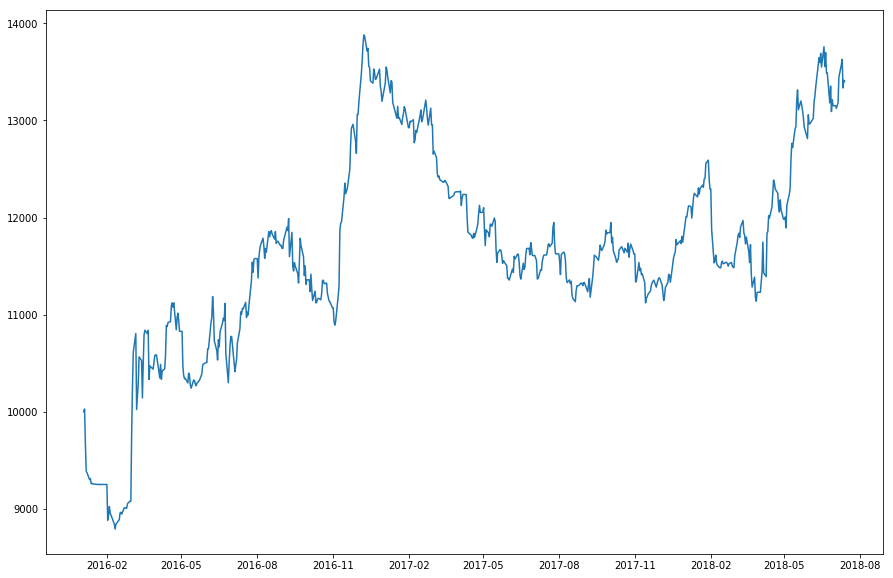

In [17]:
plt.figure(figsize=(15,10))
plt.plot(df['NAV'])

In [18]:
df

,X,PBR,BAC,CZR,AKS,AMD,TWTR,DVN,CHK,FCX,...,MS,RIG,IQ,pos_amts,pos_cost,pos_cost_tot,pos_values,pos_value_tot,cash,NAV
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,7.946530,4.252493,15.801085,7.74,2.35,2.770000,22.559999,31.447899,4.95,6.513027,...,29.865728,12.55,NaN,"{'X': 66.23, 'PBR': 123.77, 'BAC': 33.31, 'CZR...","{'X': 526.3, 'PBR': 526.33, 'BAC': 526.33, 'CZ...",10000.20,"{'X': 526.3, 'PBR': 526.33, 'BAC': 526.33, 'CZ...",10000.20,-0.20,10000.00
2016-01-05,8.024630,4.172633,15.801085,7.91,2.43,2.750000,21.920000,31.944145,5.01,6.672123,...,29.675983,12.15,NaN,"{'X': 66.23, 'PBR': 123.77, 'BAC': 33.31, 'CZR...","{'X': 526.3, 'PBR': 526.33, 'BAC': 526.33, 'CZ...",10000.20,"{'X': 531.47, 'PBR': 516.45, 'BAC': 526.33, 'C...",10028.58,-0.20,10028.38
2016-01-06,7.741521,3.943039,15.464480,7.33,2.52,2.510000,21.389999,29.394838,4.68,6.135171,...,28.935980,11.52,NaN,"{'X': 66.23, 'BAC': 33.31, 'AKS': 223.97, 'KOR...","{'X': 526.3, 'BAC': 526.33, 'AKS': 526.33, 'KO...",5263.25,"{'X': 512.72, 'BAC': 515.12, 'AKS': 564.4, 'KO...",5247.48,4418.62,9666.10
2016-01-07,7.126496,3.803285,14.906683,6.55,2.33,2.280000,20.260000,27.302851,4.41,5.578333,...,27.493925,11.00,NaN,"{'AKS': 223.97, 'KORS': 13.04, 'S': 149.52, 'T...","{'AKS': 526.33, 'KORS': 526.42, 'S': 526.31, '...",2105.35,"{'AKS': 521.85, 'KORS': 508.04, 'S': 500.89, '...",2050.54,7334.65,9385.19
2016-01-08,6.872674,3.743391,14.618165,6.71,2.33,2.140000,19.980000,27.730982,4.44,5.379462,...,26.924692,10.75,NaN,"{'AKS': 223.97, 'S': 149.52, 'TEVA': 8.57}","{'AKS': 526.33, 'S': 526.31, 'TEVA': 526.29}",1578.93,"{'AKS': 521.85, 'S': 508.37, 'TEVA': 513.4}",1543.62,7827.43,9371.05
2016-01-11,6.657905,3.703462,14.723957,6.24,2.06,2.340000,19.650000,26.242264,4.17,4.285671,...,27.000589,10.34,NaN,"{'S': 149.52, 'TEVA': 8.57}","{'S': 526.31, 'TEVA': 526.29}",1052.60,"{'S': 502.39, 'TEVA': 511.7}",1014.09,8288.81,9302.90
2016-01-12,6.726240,3.483850,14.723957,6.62,2.18,2.390000,19.620001,25.025991,4.05,4.086800,...,27.000589,10.28,NaN,"{'S': 149.52, 'TEVA': 8.57}","{'S': 526.31, 'TEVA': 526.29}",1052.60,"{'S': 503.88, 'TEVA': 519.04}",1022.92,8288.81,9311.73
2016-01-13,6.579805,3.344096,14.329649,6.14,2.04,2.250000,18.680000,24.130817,3.64,3.718889,...,25.511099,9.80,NaN,{'TEVA': 8.57},{'TEVA': 526.29},526.29,{'TEVA': 505.98},505.98,8752.32,9258.30
2016-01-14,7.126496,3.593656,14.416204,6.33,2.05,2.210000,19.000000,25.259518,3.71,4.176291,...,25.757767,10.54,NaN,{'TEVA': 8.57},{'TEVA': 526.29},526.29,{'TEVA': 509.45},509.45,8752.32,9261.77


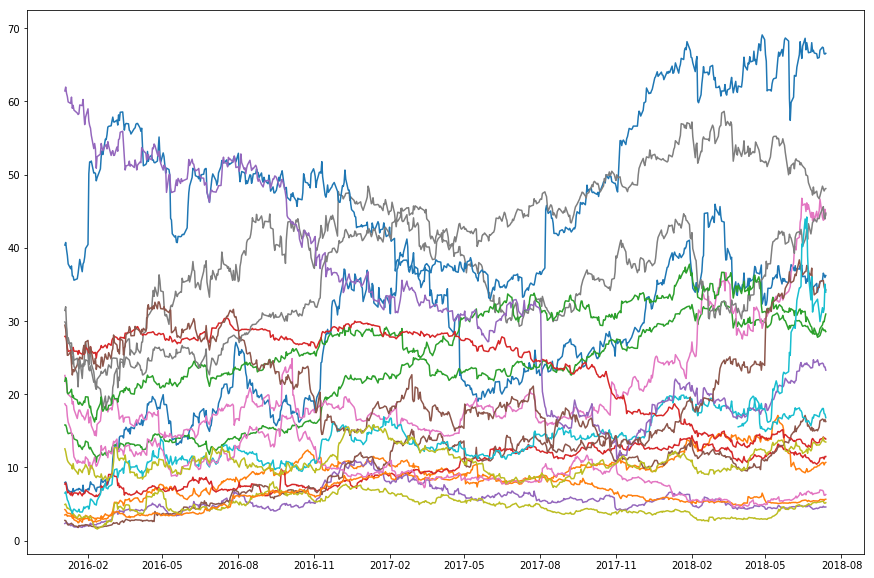

In [19]:
plt.figure(figsize=(15,10))
plt.plot(df.iloc[:, 0:len(symbol_list)])

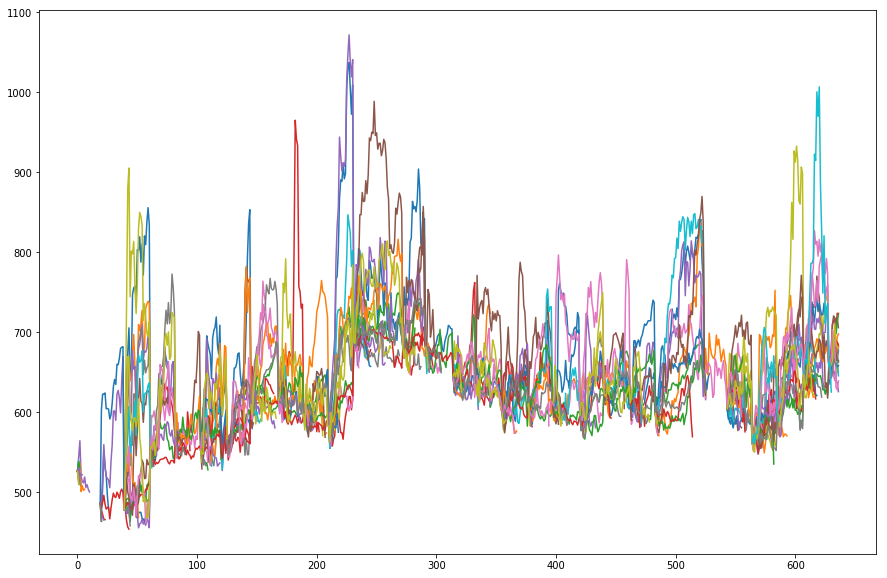

In [20]:
new_df = pd.DataFrame()

for j in symbol_list:
    
    try:
        pos_val_rec = [df.loc[df.index[x], 'pos_values'][j] for x in range(len(df.index))]
        
    except KeyError:
        
        pos_val_rec = []
        
        for x in range(len(df.index)):
            
            try:
               
                pos_val_rec.append(df.loc[df.index[x], 'pos_values'][j])
            
            except KeyError:
                
                pos_val_rec.append(np.nan) # Put in something here to deal with NaN's.
            
    new_df[j] = pos_val_rec
    
new_df  

plt.figure(figsize=(15,10))
plt.plot(new_df)